In [1]:
import sys
import os
import time
import warnings
sys.path.append(os.path.abspath(os.path.join('../../')))
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from evaluation import full_evaluate

In [3]:
# Reading the dataset
df = pd.read_csv("../../datasets/final_features_dataset.csv")

# Separating features and target variable
X = df.drop(columns=['is_fraud', 'Unnamed: 0'])
y = df['is_fraud']

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Convert data to arrays if they are not already
X_train = X_train.values if isinstance(X, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y, pd.Series) else y_train

In [4]:
# Defining the hyperparameter search space
hyperparameter_space = {
    "tol": [0, 1],
    "C": [0.1, 100],
    "fit_intercept": [-1, 1],
    "intercept_scaling": [1, 5],
    "class_weight": [-1, 1],
    "max_iter": [100, 10000],
    "multi_class": [0, 3],
    "warm_start": [-1, 1],
    "l1_ratio": [0, 1]
}


# Define fitness function to evaluate model performance
def fitness(hyperparameters, get_model = False):
    """
    Function to evaluate the fitness of decision tree model with given hyperparameters.

    Args:
    hyperparameters (list): List of hyperparameter values.
    get_model (bool): If True, returns the model only, otherwise returns the fitness score.

    Returns:
    float or DecisionTreeClassifier: Fitness score if get_model=False, else the model itself.
    """
    # Check if hyperparameters are within defined ranges
    for i, value in enumerate(hyperparameters):
        param_name = list(hyperparameter_space.keys())[i]
        range_min = hyperparameter_space[param_name][0]
        range_max = hyperparameter_space[param_name][1]
        if not (range_min <= value <= range_max):
            return float('-inf') # Penalize if hyperparameters are out of range

    # Determine multi_class
    multi_class = 'auto'
    if round(hyperparameters[6]) == 2: 
        multi_class = 'ovr'
    elif round(hyperparameters[6]) == 3: 
        multi_class = 'multinomial'

    # Create logistic regression model with specified hyperparameters
    model = LogisticRegression(
        tol = hyperparameters[0],
        C = hyperparameters[1],
        fit_intercept =  hyperparameters[2]>0,
        intercept_scaling = hyperparameters[3],
        class_weight = 'balanced' if  hyperparameters[4]>0 else None,
        max_iter =  round(hyperparameters[5]),
        multi_class = multi_class,
        warm_start = hyperparameters[7]>0,
        l1_ratio = hyperparameters[8],
        random_state=0
    )

    # If only model is requested, return the model
    if get_model:
        print('Best parameters', {
            "tol": hyperparameters[0],
            "C": hyperparameters[1],
            "fit_intercept":  hyperparameters[2]>0,
            "intercept_scaling": hyperparameters[3],
            "class_weight": 'balanced' if  hyperparameters[4]>0 else None,
            "max_iter":  round(hyperparameters[5]),
            "multi_class": multi_class,
            "warm_start": hyperparameters[7]>0,
            "l1_ratio": hyperparameters[8],
        })
        return model
    else:
        # Initialize cross-validation
        cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
        cv_results = []
        
        # Perform cross-validation
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            
            # Fit the model
            model = model.fit(X_train_fold, y_train_fold)
            
            # Make predictions
            y_train_pred = model.predict(X_train_fold)
            y_test_pred = model.predict(X_test_fold)
            
            # Calculate evaluation metrics
            f1_train = f1_score(y_train_fold, y_train_pred)
            f1_test = f1_score(y_test_fold, y_test_pred)

            # Store results
            cv_results.append({'f1_train': f1_train, 'f1_test': f1_test})
            
        # Extracting F1 scores for training, testing, and validation sets from cross-validation results
        f1_train = np.array([fold["f1_train"] for fold in cv_results])
        f1_test = np.array([fold["f1_test"] for fold in cv_results])

        # Initialize the score variable to negative infinity
        score = float("-inf")
        # Check if the standard deviation of the mean F1 scores across training, testing, and validation sets is less than 0.02
        if np.array([f1_train.mean(), f1_test.mean()]).std()<0.01:
            # If the condition is met, set the score to the mean F1 score of the validation set
            score = f1_test.mean()
        return score

New best 0.0
New best 0.07362498075465322
New best 0.07581297947816934
New best 0.07585159806443308
New best 0.07585205016044044
New best 0.0758619735299757
New best 0.07612790148440814
New best 0.0761708645049213
New best 0.07617173935253906
New best 0.07882801423923583
New best 0.07953818699611911


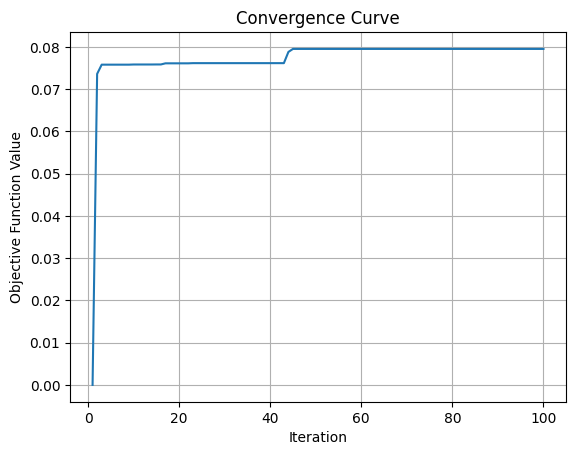

Best parameters {'tol': 0.0023150635818431175, 'C': 0.1, 'fit_intercept': False, 'intercept_scaling': 1.0344613539493757, 'class_weight': None, 'max_iter': 112, 'multi_class': 'auto', 'warm_start': False, 'l1_ratio': 0.04070012306509484}
Training set Counter({0: 8780, 1: 396}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8780, 1: 396}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8780, 1: 396}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8781, 1: 396}) Test set Counter({0: 2926, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Fold 1: (Train F1: 0.08, Test F1: 0.08, Validation F1: 0.08, Precision: 0.04, Recall: 0.49, Accuracy: 0.49).
Fold 2: (Train F1: 0.08, Test F1: 0.07, Validation F1: 0.07, Precision: 0.04, Recall: 0.50, Accuracy: 0.45).
Fold 3: (Train F1: 0.08, Test F1: 0.08, Validation F1: 0.07, Precision: 

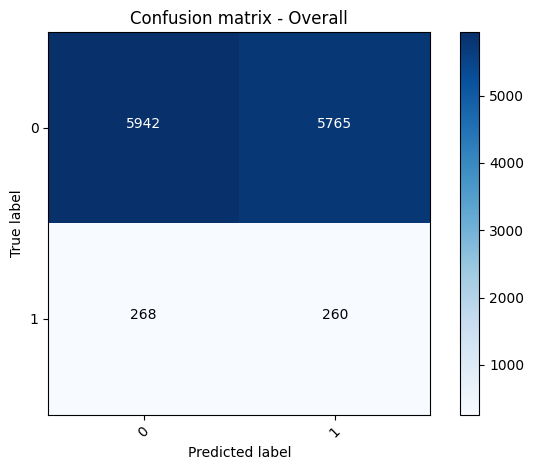

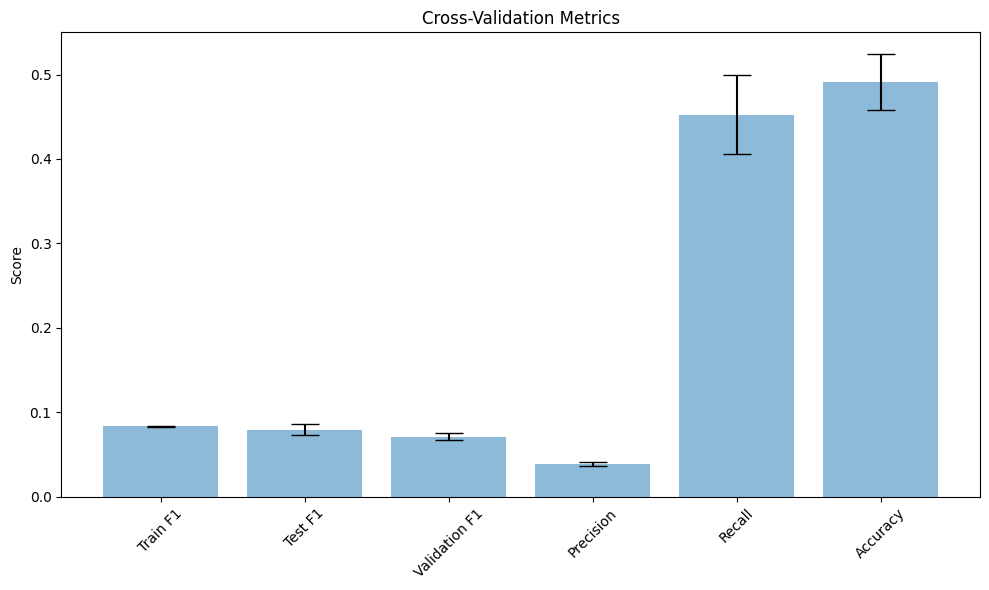

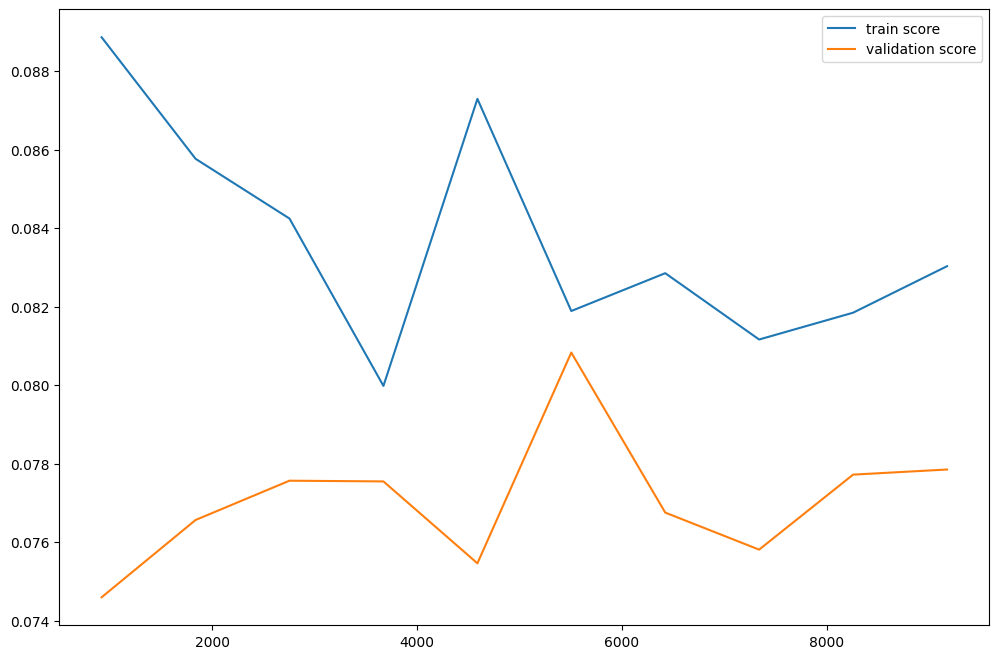

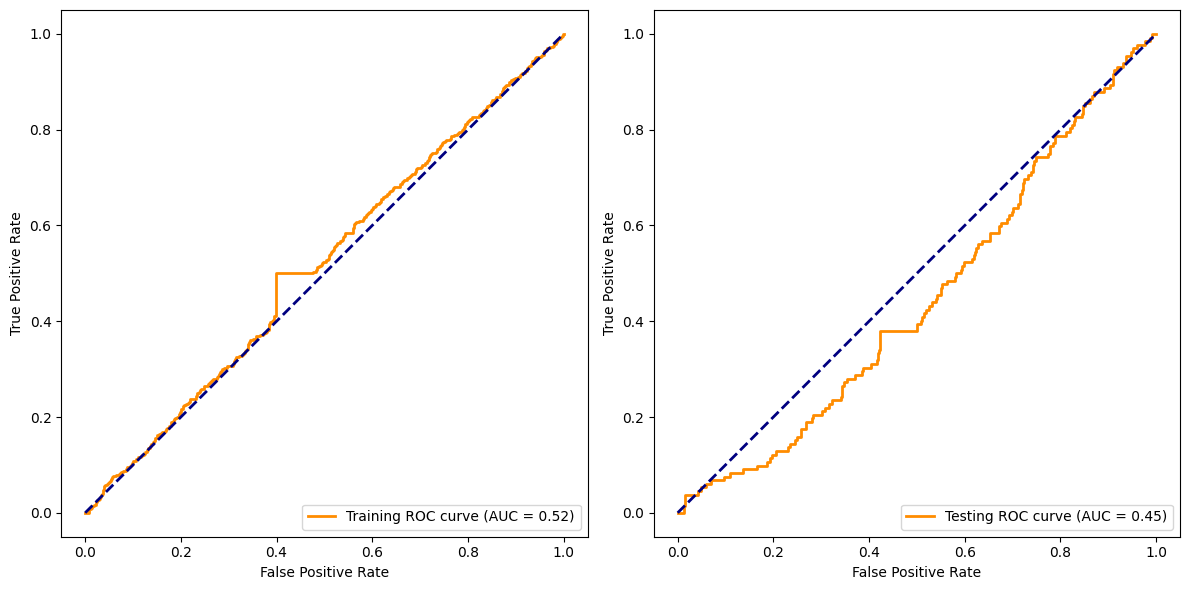

67.47302460670471 seconds


In [5]:
# Measure the start time for the optimization process
starting = time.time()

# Perform hyperparameter optimization using the Harris Hawks Optimization algorithm
# The `full_evaluate` function evaluates the fitness of each individual (hawk) in the population
# by calling the `fitness` function defined earlier
# `fitness` is the function that computes the fitness score for each set of hyperparameters
# `X` is the feature dataset
# `y` is the target variable
# `hyperparameter_space` defines the search space for hyperparameters
# `sampling` is an optional parameter to specify the sampling method
# `max_iter` specifies the maximum number of iterations for the HHO algorithm
# `pop_size` specifies the population size for each iteration
full_evaluate.full_evaluate(fitness, X, y, hyperparameter_space, sampling=None, max_iter=100, pop_size=5)

# Measure the time taken for optimization by calculating the difference between the start time and the current time
exec_time = time.time() - starting

# Print the execution time in seconds
print(exec_time, "seconds")